In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

# 1. Эксперимент с рефакторингом

Сделали рефакторинг бэкенда. Нужно проверить не ухудшилась ли скорость ответов на запросы.

- Проверяем гипотезу о равенстве средних
- Наблюдения считаем независимыми
- Критерий - тест Стьюдента
- Размеры групп - данные за 1 день, распределяем запросы случайно на две группы
- Ожидаемый эффект - 10 миллисекунд
- Уровень значимости - 0.01
- Допустимая вероятность ошибки второго рода - 0.05

Данные в файле `02-backend.csv` содержат информацию:
- day - день, в который было сделано измерение
- group - контрольная группа ('а') и экспериментальная группа ('b'), данные полученные до эксперимента ('-')
- load_time - время обработки запроса в миллисекундах

### Загрузим и изучим данные

In [2]:
df = pd.read_csv('../data/02-backend.csv')
df

,day,group,load_time
0,0,-,79.0
1,0,-,51.6
2,0,-,70.1
3,0,-,68.6
4,0,-,60.3
...,...,...,...
80996,7,a,49.0
80997,7,b,66.4
80998,7,b,64.9
80999,7,b,64.4


Посмотрим на распределения по дням и группам

In [3]:
df.groupby(['day', 'group'])[['load_time']].agg(['count', 'mean', 'max', 'min'])

load_time                        
              count       mean    max   min
day group                                  
0   -         10867  70.226889  724.7   0.0
1   -         10691  70.586568  696.7   0.0
2   -         10414  70.146399  727.7   0.0
3   -         10283  70.418098  730.3   0.0
4   -         10987  70.293647  659.2   0.0
5   -          9432  70.516974  721.2   0.0
6   -          9278  70.037045  692.4   0.0
7   a          4449  71.051922  680.5   0.0
    b          4600  73.627326  702.7  44.3

Построим оценки плотностей распределений

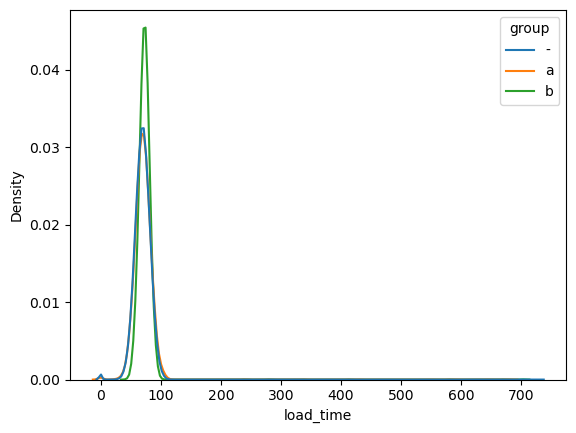

In [4]:
sns.kdeplot(data=df, hue='group', x='load_time', common_norm=False);

Изучим количество сильных отклонений

In [5]:
df['less_20'] = (df['load_time'] < 20).astype(int)
df['more_150'] = (df['load_time'] > 150).astype(int)
df.groupby('group')[['less_20', 'more_150']].agg(['sum', 'mean'])

less_20           more_150          
          sum      mean      sum      mean
group                                     
-         281  0.003905      120  0.001668
a          13  0.002922        8  0.001798
b           0  0.000000        9  0.001957

Посмотрим на распределения без "хвостов"

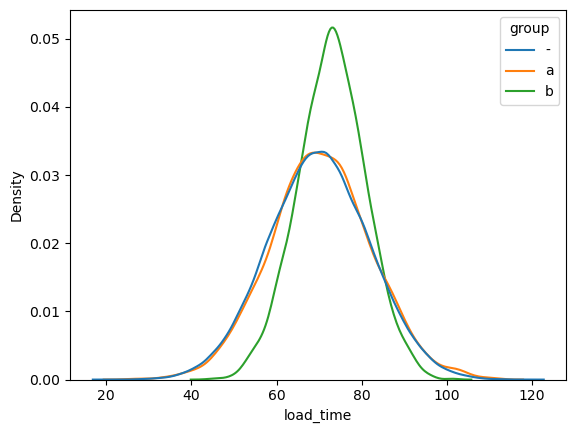

In [6]:
sns.kdeplot(data=df[df['load_time'].between(20, 150)], hue='group', x='load_time', common_norm=False);

- распределения до эксперимента и в контрольной группе похожи;
- распределение экспериментальной группы отличается: среднее больше, дисперсия меньше.

### Проверка корректности и оценка мощности

Воспользуемся функцией с прошлого семинара

In [7]:
def plot_pvalue_distribution_power(dict_pvalues, alpha=0.01):
    """Рисует графики распределения pvalue."""
    X = np.linspace(0, 1, 1000)
    for key, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues <= x) for x in X]
        prob_p = np.mean(np.array(pvalues) < alpha)
        plt.plot(X, Y, label=f'{key}, prob_p={prob_p:0.2f}')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

Проведём синтетические АА и АB тесты.

Для каждого дня будем случайно разбивать все запросы на две группы.

**Задание 1**. Допишите код для разбиения на группы. Чему равна оценка мощности?

  0%|          | 0/7 [00:00<?, ?it/s]

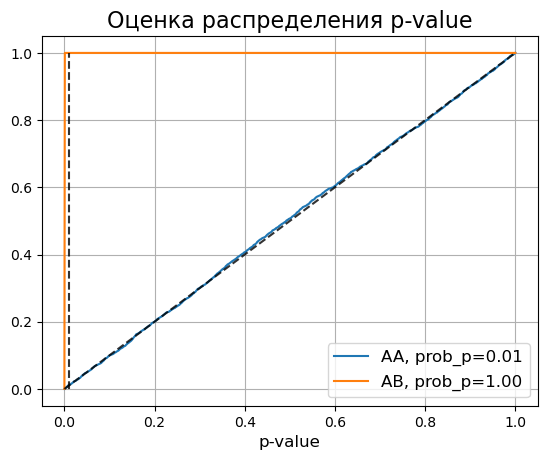

In [8]:
n_iter = 3500
effect = 10
dict_pvalues = defaultdict(list)
for day in tqdm(range(7)):
    values = df[df['day'] == day]['load_time'].values
    len_ = len(values)
    for _ in range(n_iter // 7):
        mask = np.random.binomial(1, 0.5, len_) == 1
        a = values[mask]
        b = values[~mask]
        dict_pvalues['AA'].append(stats.ttest_ind(a, b).pvalue)
        dict_pvalues['AB'].append(stats.ttest_ind(a, b+effect).pvalue)
plot_pvalue_distribution_power(dict_pvalues)

### Выбросы

- В данных были нули и большие значения, что с ними делать?
- Может ли дисперсия увеличиться, если удалить выброс?

**Задание 2.** Удалите нули, как изменится мощность при `effect=1.5`?

  0%|          | 0/7 [00:00<?, ?it/s]

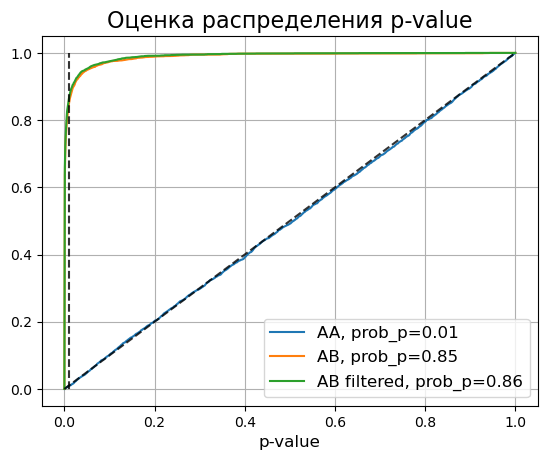

In [9]:
n_iter = 3500
effect = 1.5
dict_pvalues = defaultdict(list)
for day in tqdm(range(7)):
    values = df[df['day'] == day]['load_time'].values
    len_ = len(values)
    for _ in range(n_iter // 7):
        mask = np.random.binomial(1, 0.5, len_) == 1
        a = values[mask]
        b = values[~mask]
        dict_pvalues['AA'].append(stats.ttest_ind(a, b).pvalue)
        dict_pvalues['AB'].append(stats.ttest_ind(a, b+effect).pvalue)
        a, b = [x[x > 0] for x in [a, b]]
        dict_pvalues['AB filtered'].append(stats.ttest_ind(a, b+effect).pvalue)
plot_pvalue_distribution_power(dict_pvalues)

### Оценка эксперимента

**Задание 3**. Оцените эксперимент. Какой результат? Какое принимаем решение?

In [10]:
df_no_zero = df[df['load_time'] > 0].copy()
a = df_no_zero[df_no_zero['group'] == 'a']['load_time'].values
b = df_no_zero[df_no_zero['group'] == 'b']['load_time'].values
print(f'mean(a)={np.mean(a):0.2f}, mean(b)={np.mean(b):0.2f}, delta={np.mean(b) - np.mean(a):0.2f}')
print('pvalue =', stats.ttest_ind(a, b).pvalue)

mean(a)=71.24, mean(b)=73.63, delta=2.38
pvalue = 5.989665981969372e-08


# 2. Bootstrap

**Бутстреп (bootstrap)** — метод оценки стандартного отклонения и вычисления доверительного интервала, основанный на многократной генерации случайных подвыборок из имеющихся данных.

### Алгоритм проверки гипотез для А/Б эксперимента:
1. Сгенерировать две подвыборки, одну из значений контрольной группы, вторую из значений экспериментальной группы;
2. Посчитать статистику по значениям подвыборок. В случае проверки гипотезы о равенстве средних, статистика — разница средних значений подвыборок;
3. Повторить первые два шага 1000 раз, получим 1000 оценок разницы средних;
4. По полученным значениям построить доверительный интервал;
5. Проверить значимость отличий: ноль находится вне доверительного интервала — отличия статистически значимы, иначе — нет.

### 3 способа построения ДИ


Нормальный ДИ:

$$[\widehat{pe} - z_{1-\frac{\alpha}{2}} *\widehat{std}, \widehat{pe} + z_{1-\frac{\alpha}{2}} *\widehat{std}]$$

Перцентильный ДИ:

$$ [\hat{q}_{\frac{\alpha}{2}}, \hat{q}_{1 - \frac{\alpha}{2}}]$$

Центральный ДИ:

$$[2*\widehat{pe} - \widehat{q}_{1-\frac{\alpha}{2}}, 2*\widehat{pe} - \widehat{q}_{\frac{\alpha}{2}}]$$

**Задание 4**. Написать 3 функции для расчета доверительных интервалов на основе бутстрепа

In [11]:
def get_normal_ci(bootstrap_stats, pe, alpha):
    """Строит нормальный доверительный интервал.

    bootstrap_stats - бутстрепные оценки
    pe - точечная оценка
    alpha - уровень значимости

    return: границы ДИ
    """
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = pe - z * se, pe + z * se
    return left, right

def get_percentile_ci(bootstrap_stats, pe, alpha):
    """Строит перцентильный доверительный интервал.

    bootstrap_stats - бутстрепные оценки
    pe - точечная оценка
    alpha - уровень значимости

    return: границы ДИ
    """
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def get_pivotal_ci(bootstrap_stats, pe, alpha):
    """Строит центральный доверительный интервал.

    bootstrap_stats - бутстрепные оценки
    pe - точечная оценка
    alpha - уровень значимости

    return: границы ДИ
    """
    left, right = 2 * pe - np.quantile(bootstrap_stats, [1 - alpha / 2,  alpha / 2])
    return left, right

n = 1000
B = 10000
alpha = 0.05

dict_ci_methods = {
    'normal': get_normal_ci,
    'percentile': get_percentile_ci,
    'pivotal': get_pivotal_ci,
}

values = np.random.exponential(size=n)
pe = np.quantile(values, 0.5)
bootstrap_stats = np.quantile(np.random.choice(values, (B, n), True), 0.5, axis=1)

for name, get_ci in dict_ci_methods.items():
    print(name, get_ci(bootstrap_stats, pe, alpha))

normal (0.5474686900439056, 0.6596568677609282)
percentile (0.55263468618413, 0.6649315713092481)
pivotal (0.5421939864955858, 0.6544908716207039)


### Отличия разных ДИ

- Если распределение бутстрепных статистик нормальное, то ДИ практически одинаковые;
- Если распределения бутстрепных статистик симметричное, то центральный и перцентильный совпадают.

Суть центрального ДИ - симметрично разворачиваем границы перцентильного ДИ относительно точечной оценки:

$$
\begin{align}
\text{left} &= 2 * \hat{pe} - \hat{q}_{1-\frac{\alpha}{2}} = \hat{pe} - \left(\hat{q}_{1-\frac{\alpha}{2}} - \hat{pe} \right) \\
\text{right} &= 2 * \hat{pe} - \hat{q}_{\frac{\alpha}{2}} = \hat{pe} + \left(\hat{pe} - \hat{q}_{\frac{\alpha}{2}} \right) 
\end{align}
$$

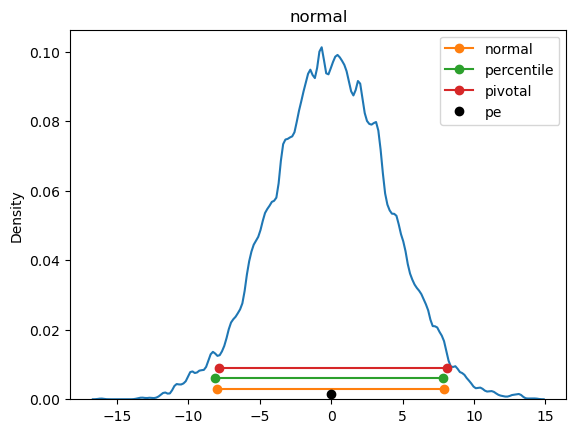

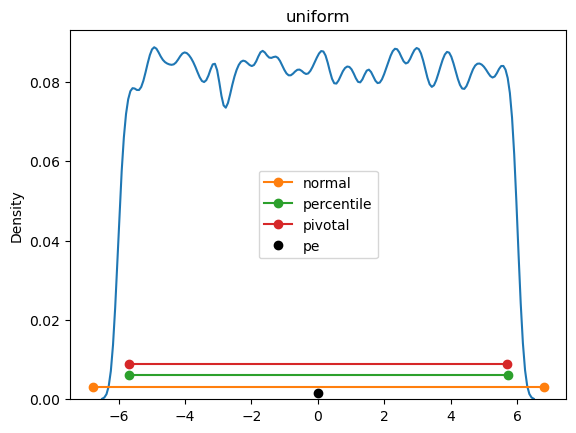

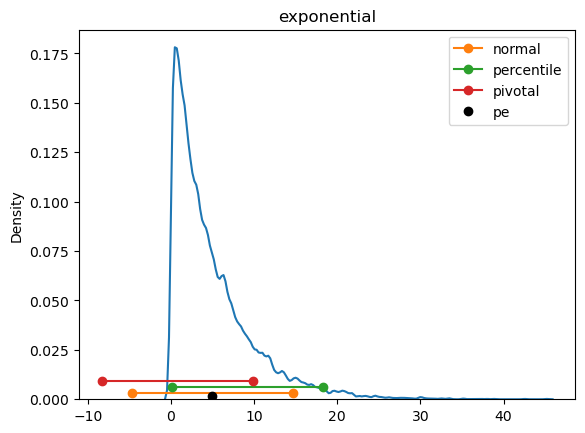

In [12]:
value_name = [
    [np.random.normal(scale=4, size=B), 'normal'],
    [np.random.uniform(-6, 6, size=B), 'uniform'],
    [np.random.exponential(5, size=B), 'exponential'],
]

for bootstrap_stats, name in value_name:
    pe = bootstrap_stats.mean()   # Так делать не надо! Нужно оценивать по исходным данным
    sns.kdeplot(x=bootstrap_stats, bw_adjust=0.3)
    step = 0.003
    for idx, (ci_name, get_ci) in enumerate(dict_ci_methods.items()):
        ci = get_ci(bootstrap_stats, pe, alpha)
        plt.plot(ci, [step*(idx+1), step*(idx+1)], 'o-', label=ci_name)
    plt.plot([pe], [step/2], 'ok', label='pe')
    plt.legend()
    plt.title(name)
    plt.show()

### Проверка корректности для разных статистик

Оценим максимум равномерного распределения

In [13]:
def print_bernoulli_ci(dict_res):
    for name, values in dict_res.items():
        std_ = (np.var(values) / len(values)) ** 0.5
        pe = np.mean(values)
        left, right = pe - 1.96 * std_, pe + 1.96 * std_
        print(f'{name}: pe={pe:0.3f}, [{left:0.3f}, {right:0.3f}]')

In [14]:
n = 100
B = 1000
n_iter = 1000
dict_res = defaultdict(list)
for _ in tqdm(range(n_iter)):
    a = np.random.uniform(size=n)
    pe = np.median(a)
    bootstrap_stats = np.median(np.random.choice(a, (B, n)), axis=1)
    for ci_name, get_ci in dict_ci_methods.items():
        ci = get_ci(bootstrap_stats, pe, alpha)
        res = 1 - int(ci[0] < 0.5 < ci[1])
        dict_res[ci_name].append(res)

print_bernoulli_ci(dict_res)

  0%|          | 0/1000 [00:00<?, ?it/s]

normal: pe=0.065, [0.050, 0.080]
percentile: pe=0.062, [0.047, 0.077]
pivotal: pe=0.144, [0.122, 0.166]


Все способы не контролируют вероятность ошибки первого рода на уровне значимости. Центрильный ДИ ближе всего.

**Задание 5.** Проведите аналогичный эксперимент для оценки 99% квантиля равномерного распределения. Какой способ построения ДИ показал наименьшую вероятность ошибки первого рода?

In [15]:
n = 100
B = 1000
n_iter = 1000
q = 0.9
dict_res = defaultdict(list)
for _ in tqdm(range(n_iter)):
    a = np.random.uniform(size=n)
    pe = np.quantile(a, q)
    bootstrap_stats = np.quantile(np.random.choice(a, (B, n)), q, axis=1)
    for ci_name, get_ci in dict_ci_methods.items():
        ci = get_ci(bootstrap_stats, pe, alpha)
        res = 1 - int(ci[0] < q < ci[1])
        dict_res[ci_name].append(res)

print_bernoulli_ci(dict_res)

  0%|          | 0/1000 [00:00<?, ?it/s]

normal: pe=0.069, [0.053, 0.085]
percentile: pe=0.060, [0.045, 0.075]
pivotal: pe=0.183, [0.159, 0.207]


### Проверка корректности для АB тестов

Проверим корректность работы для проверки гипотез о равенстве средних и квантилей.

In [16]:
n = 100
B = 1000
n_iter = 1000

dict_functions = {
    'mean': lambda x: np.mean(x, axis=1),
    'quantile90': lambda x: np.quantile(x, q=0.9, axis=1),
    'quantile99': lambda x: np.quantile(x, q=0.99, axis=1),
    'max': lambda x: np.max(x, axis=1),
}
dict_res = defaultdict(list)
for _ in tqdm(range(n_iter)):
    a, b = np.random.uniform(size=(2, n))
    for func_name, func in dict_functions.items():
        pe = func([b])[0] - func([a])[0]
        bootstrap_stats = (
            func(np.random.choice(b, (B, n)))
            - func(np.random.choice(a, (B, n)))
        )
        for ci_name, get_ci in dict_ci_methods.items():
            ci = get_ci(bootstrap_stats, pe, alpha)
            res = 1 - int(ci[0] < 0 < ci[1])
            dict_res[f'stat_{func_name} ci_{ci_name}'].append(res)

print_bernoulli_ci(dict_res)

  0%|          | 0/1000 [00:00<?, ?it/s]

stat_mean ci_normal: pe=0.043, [0.030, 0.056]
stat_mean ci_percentile: pe=0.044, [0.031, 0.057]
stat_mean ci_pivotal: pe=0.050, [0.036, 0.064]
stat_quantile90 ci_normal: pe=0.052, [0.038, 0.066]
stat_quantile90 ci_percentile: pe=0.041, [0.029, 0.053]
stat_quantile90 ci_pivotal: pe=0.106, [0.087, 0.125]
stat_quantile99 ci_normal: pe=0.048, [0.035, 0.061]
stat_quantile99 ci_percentile: pe=0.057, [0.043, 0.071]
stat_quantile99 ci_pivotal: pe=0.107, [0.088, 0.126]
stat_max ci_normal: pe=0.078, [0.061, 0.095]
stat_max ci_percentile: pe=0.134, [0.113, 0.155]
stat_max ci_pivotal: pe=0.138, [0.117, 0.159]


Итого про бутстреп:

Плюсы - весьма универсальный способ проверки гипотез.

Минусы:
- скорость работы;
- плохо работает для "краевых" статистик (например, максимум);
- плохо работает, если выборка не отражает свойства исходного распределения.

### Возвращаемся к эксперименту с рефакторингом бэкенда

Проверим как работает бутстреп для проверки гипотезы о равенстве 99% квантилей.

In [17]:
B = 1000
n_iter = 350
effect = 3
q = 0.99
dict_res = defaultdict(list)
for day in range(7):
    values = df[df['day'] == day]['load_time'].values
    values = values[values > 0]
    len_ = len(values)
    for _ in tqdm(range(n_iter // 7)):
        mask = np.random.binomial(1, 0.5, len_) == 1
        a = values[mask]
        b = values[~mask]
        pe = np.quantile(b, q) - np.quantile(a, q)
        bootstrap_stats = (
            np.quantile(np.random.choice(b, (B, len(b))), q, axis=1)
            - np.quantile(np.random.choice(a, (B, len(a))), q, axis=1)
        )
        for ci_name, get_ci in dict_ci_methods.items():
            ci = get_ci(bootstrap_stats, pe, alpha)
            res = 1 - int(ci[0] < 0 < ci[1])
            dict_res['AA ' + ci_name].append(res)
            ci = get_ci(bootstrap_stats + effect, pe + effect, alpha)
            res = 1 - int(ci[0] < 0 < ci[1])
            dict_res['AB ' + ci_name].append(res)
print_bernoulli_ci(dict_res)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

AA normal: pe=0.063, [0.037, 0.088]
AB normal: pe=0.794, [0.752, 0.837]
AA percentile: pe=0.049, [0.026, 0.071]
AB percentile: pe=0.809, [0.767, 0.850]
AA pivotal: pe=0.086, [0.056, 0.115]
AB pivotal: pe=0.766, [0.721, 0.810]


**Задание 6**. Проверьте гипотезу о равенстве 99% квантиль. Как изменился квантиль? Значимы ли отличия?

In [18]:
q = 0.99
B = 10000

df_no_zero = df[df['load_time'] > 0].copy()
a = df_no_zero[df_no_zero['group'] == 'a']['load_time'].values
b = df_no_zero[df_no_zero['group'] == 'b']['load_time'].values

pe = np.quantile(b, q) - np.quantile(a, q)
bootstrap_stats = (
    np.quantile(np.random.choice(b, (B, len(b))), q, axis=1)
    - np.quantile(np.random.choice(a, (B, len(a))), q, axis=1)
)
ci = get_percentile_ci(bootstrap_stats, pe, alpha)

print(f'quantile(a) = {np.quantile(a, q):0.2f}, quantile(b) = {np.quantile(b, q):0.2f}')
print(f'pe = {pe:0.2f}')
print(f'ci = [{ci[0]:0.3f}, {ci[1]:0.3f}]')

quantile(a) = 101.33, quantile(b) = 91.90
pe = -9.43
ci = [-10.999, -7.100]


# 3. Построение собственного критерия

Подходит для специфичных статистик и данных, для которых обычные критерии не работают. Требует много исторических данных.

Чтобы построить критерий для проверки гипотезы, нужно определить статистику и узнать её распределение при верности нулевой гипотезы. Оценить распределение статистики можно по историческим данным с помощью синтетических А/А тестов. Для каждого синтетического А/А теста вычислим и запомним значение статистики, повторим это большое количество раз. По полученным значениям оценим функцию распределения. Из функции распределения по статистике эксперимента можно получить p-value.

$$
\text{p-value} = \left\{
   \begin{aligned}
    &\mathbb{P}(T \le t | H_0) &&,\text{для левосторонней гипотезы} \\
    &\mathbb{P}(T \ge t | H_0) &&,\text{для правосторонней гипотезы} \\
    &2\times\min\left(\mathbb{P}(T \le t | H_0),\ \mathbb{P}(T \ge t | H_0)\right) &&,\text{для двусторонней гипотезы} \\
   \end{aligned}
\right.
$$

### Пример
Построим критерий для проверки гипотезы о равенстве максимумов для данных из равномерного распределения.

1. нулевая гипотеза - максимумы равны;
2. статистика критерия - разность максимумов;
3. проведём синтетические А/А тесты на исторических данных, чтобы оценить распределение статистики;

In [19]:
sample_size = 100
statistic_size = 100_000
history_size = 1_000_000

history = np.random.uniform(size=history_size)

batch_size = 1000
statistic_list = []
for _ in tqdm(range(statistic_size // batch_size)):
    history_sample = np.random.choice(
        history,
        size=(batch_size, 2, sample_size),
        replace=False
    )
    a_max = history_sample[:, 0, :].max(axis=1)
    b_max = history_sample[:, 1, :].max(axis=1)
    delta_max = b_max - a_max
    statistic_list += list(delta_max)
statistic_values = np.array(statistic_list)

  0%|          | 0/100 [00:00<?, ?it/s]

Посмотрим на распределение статистики. Сравним с плотностью нормального распределения.

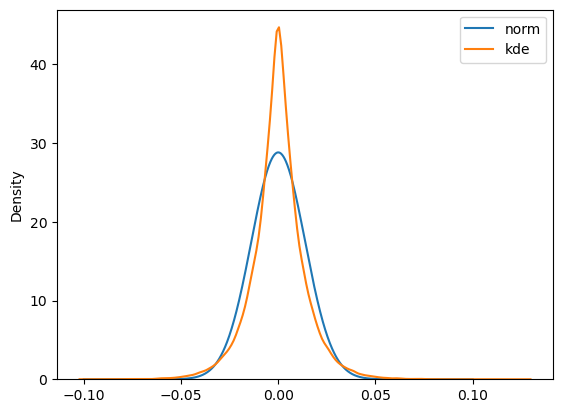

In [20]:
std = np.std(statistic_values)
x = np.linspace(-0.1, 0.1, 1000)
y = stats.norm.pdf(x, loc=0, scale=std)
plt.plot(x, y, label='norm')
sns.kdeplot(x=statistic_values, label='kde')
plt.legend();

**Задание 7.** Напишите функцию, которая вычисляет p-value для проверки двусторонней гипотезы.

In [21]:
def check_my_statistical_test(a, b, statistic_values):
    """Проверяет гипотезу о равенстве максимумов.

    a - значения контрольной группы
    b - значения экспериментальной группы
    statistic_values - значения разности максимумов

    return - pvalue
    """
    pe = b.max() - a.max()
    part_less = np.mean(statistic_values < pe)
    pvalue = 2 * min(part_less, 1 - part_less)
    return pvalue

Проверим корректность работы критерия

  0%|          | 0/10000 [00:00<?, ?it/s]

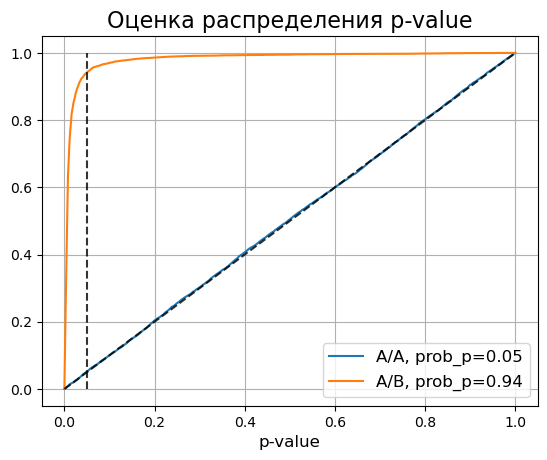

In [22]:
effect = 0.05
dict_pvalues = defaultdict(list)
for _ in tqdm(range(10000)):
    a, b = np.random.uniform(size=(2, sample_size))
    pvalue = check_my_statistical_test(a, b, statistic_values)
    dict_pvalues['A/A'].append(pvalue)
    b += effect
    pvalue = check_my_statistical_test(a, b, statistic_values)
    dict_pvalues['A/B'].append(pvalue)
plot_pvalue_distribution_power(dict_pvalues, alpha=0.05)

Созданный критерий работает только для определённых данных, статистики и размера групп. Если что-то поменять, то нужно пересчитывать распределение статистики.

Если изменить размер групп и не пересчитать распределение статистики, критерий будет работать некорректно

  0%|          | 0/10000 [00:00<?, ?it/s]

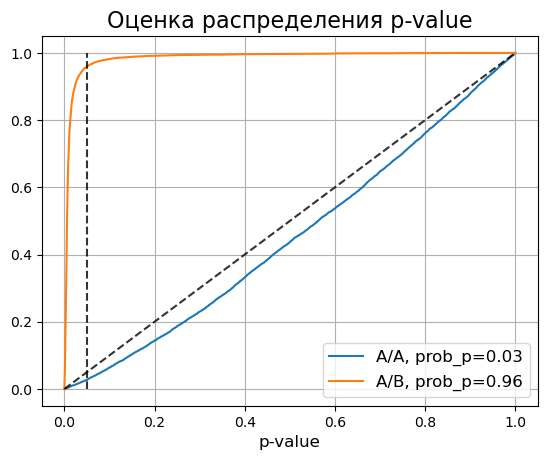

In [23]:
effect = 0.05
dict_pvalues = defaultdict(list)
for _ in tqdm(range(10000)):
    a, b = np.random.uniform(size=(2, sample_size+20))
    pvalue = check_my_statistical_test(a, b, statistic_values)
    dict_pvalues['A/A'].append(pvalue)
    b += effect
    pvalue = check_my_statistical_test(a, b, statistic_values)
    dict_pvalues['A/B'].append(pvalue)
plot_pvalue_distribution_power(dict_pvalues, alpha=0.05)